# In this file
## Load protein sequence data and int -> sym dictionary 
## HMM inference on held-out set
## Plot loss by position

In [1]:
from util import *

name_pickle_path = "./aligned/names.p"
names = pickle.load(open(name_pickle_path, 'rb') )
int_to_name_dict = "./aligned/integer_to_symbol_dictionary.p"
int_to_name_dict = pickle.load(open(int_to_name_dict, 'rb') )
#data_pickle_path = './aligned/data.p'
data_pickle_path = './Tr_2.pkl'
dataset = pickle.load(open(data_pickle_path, "rb"))
dataset = dataset[:, 1:-1]
#print(set(dataset.reshape(-1)))

#test_dataset = dataset[ :1000 ] 
#dataset =  dataset[ 1000: ]

model = hmm.MultinomialHMM(n_components=23)

num_samples, num_symbols = dataset.shape
dataset_vec = np.concatenate(dataset).reshape(-1, 1) # 

'''need to map all values  > 17 to one value lower, comply with multinomialHMM'''
replace = {18: 17, 19: 18, 20: 19, 21: 20, 22: 21} 
mp = np.arange(0,max(dataset_vec)+1)
mp[ list(replace.keys() ) ] = list( replace.values() )
dataset_vec = mp[dataset_vec]

lengths = [ 84 for x in range(num_samples) ]
dataset = dataset_vec.reshape(-1, 84)

load = True
if load:
    model = joblib.load('filename.pkl')
else: 
    model.fit(dataset_vec, lengths)
    joblib.dump(model, "filename.pkl")

some utils, e.g. converting int tokens to amino acids 

In [2]:
pca = PCA(n_components = 2)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'black', 'purple', 'olive']
plt.gcf().set_size_inches(18.5, 10.5)

def int_to_sym(int_sequence):   
    symbols = []
    for symbol_index in int_sequence:
        symbol_index_processed = symbol_index # sometimes array of arrays is passed
        #print(symbol_index_processed, type(symbol_index_processed))
        
        if type( symbol_index ) != np.int64:
            symbol_index_processed = symbol_index[0]
        
        if symbol_index_processed >= 17:
            symbols.append( int_to_name_dict[symbol_index_processed+1] )
        else:
            symbols.append( int_to_name_dict[symbol_index_processed] )
    return symbols
print(int_to_name_dict)

{17: 'SOS', 12: 'N', 8: 'I', 19: 'V', 3: 'D', 1: 'A', 9: 'K', 5: 'F', 13: 'P', 11: 'M', 22: 'Y', 21: 'X', 0: '-', 10: 'L', 18: 'T', 7: 'H', 6: 'G', 16: 'S', 4: 'E', 15: 'R', 14: 'Q', 2: 'C', 20: 'W'}


In [35]:
X, Z = model.sample(200)
#X = [i + 1 if i >= 17 else i for i in X]
sym = ''.join(int_to_sym(X) ).replace('-','')
#for  i, f in zip(X, sym):
#    print(i, f)
sym


'YEFALLANDVSLQRLIDGFDANGNYKTMFKLEWLQFIVYLEYVAFSGGAEHSFFQNTRKEKDELFEYIGMLIVFFQEYGSSGKFLRIDMGVMSIIFDRTDMLQLFSDHHCVRGRPPGAILLGLVVA'

Plotting HMM's latent state trajectory for a single sample

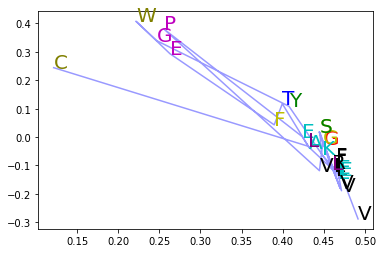

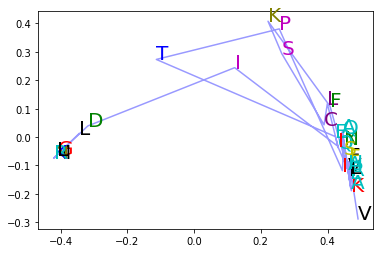

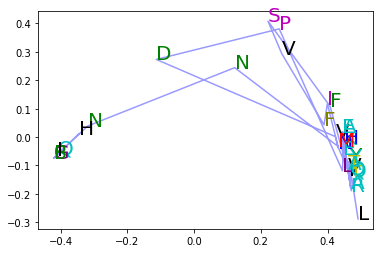

In [3]:

# PCA entire dataset but plot only first sample, next line will take a while
state_seq_prob = model.predict_proba(dataset_vec[:10*84], lengths[:10])
two_dim_Z = pca.fit_transform(state_seq_prob)  

for sample_num in [0, 1, 2]:
    example_sample = dataset_vec[ sample_num*84: (sample_num+1)*84]
    example_sample_index = np.where( example_sample != 0)[0]
    short_example_sample = example_sample[ example_sample_index ]

    # get state probabilities and hidden state
    state_sequence = model.predict(example_sample, [84])

    #plt.scatter( two_dim_Z[0:84,0], two_dim_Z[0:84,1], c = state_sequence, label = int_to_sym(example_sample)  )

    #print(state_sequence, example_sample_index)
    #state_sequence = state_sequence[example_sample_index]
    labels = int_to_sym(example_sample)

    plt.plot( two_dim_Z[ example_sample_index ,0], two_dim_Z[example_sample_index, 1], c = 'b', alpha = 0.4)#state_sequence  )

    for i in example_sample_index:  #range( len(state_sequence) ):
        if labels[i] != '-':
            plt.text(two_dim_Z[i,0], two_dim_Z[i,1], labels[i%84], fontsize=20, color = colors[state_sequence[i%84] ])

    plt.show()

In [4]:
#model.transmat_
model.emissionprob_.shape

(10, 22)

In [5]:
X, Z = model.sample(84)
"".join(int_to_sym(X))

'LGG--LIRAEVKVYSHGNRDYNRPGVVKQSGA-LLAHNFDK-----YRDF------AARAIKLDLRENNLLKKPAAQFAFQSVE'

In [22]:
f = []
for index, sample in enumerate(testset):
    sample = sample.reshape(-1, 1)
    sample = mp[sample]
    
    state_seq = model.predict(sample)
    
    best_pred_at_state = np.argmax(model.emissionprob_[state_seq], axis = 1 ) 
    #pred =  int_to_sym(best_pred_at_state) 
    #target =  int_to_sym(sample) 
    f.append( best_pred_at_state )
    #for position in range(84):
    #    position_losses[position] += hamming_loss( [target[position]], [pred[position]]  )
    
    if index % 1000 == 0:
        print(index)
    
hamming_loss( testset.reshape(-1), np.array(f).reshape(-1) )

0
1000
2000
3000
4000
5000
6000
7000


0.45704083420960395

In [7]:
test_set_path = './Te_2.pkl'
testset = pickle.load(open(test_set_path, "rb"))
testset = testset[:, 1:-1]

#print(testset.shape)
position_losses = np.zeros(84)
for index, sample in enumerate(testset):
    sample = sample.reshape(-1, 1)
    sample = mp[sample]
    
    state_seq = model.predict(sample)
    
    best_pred_at_state = np.argmax(model.emissionprob_[state_seq], axis = 1 ) 
    pred =  int_to_sym(best_pred_at_state) 
    target =  int_to_sym(sample) 
    
    for position in range(84):
        position_losses[position] += hamming_loss( [target[ position]], [pred[ position]]  )
    
    if index % 5000 == 0 and index > 0:
        break #print(index)
    
position_losses /= 5000 #testset.shape[0]

In [13]:
hmm_test_loss = 0
for index, sample in enumerate(testset):
    if index % 5000 == 0 and index >0:
        break
    
    sample = sample.reshape(-1, 1)
    sample = mp[sample]
    
    state_seq = model.predict(sample)
    
    best_pred_at_state = np.argmax(model.emissionprob_[state_seq], axis = 1 ) 
    pred =  int_to_sym(best_pred_at_state) 
    target =  int_to_sym(sample) 
    
    #print()
    
    hmm_test_loss += hamming_loss( target, pred )
hmm_test_loss/5000

0.40547619047618677

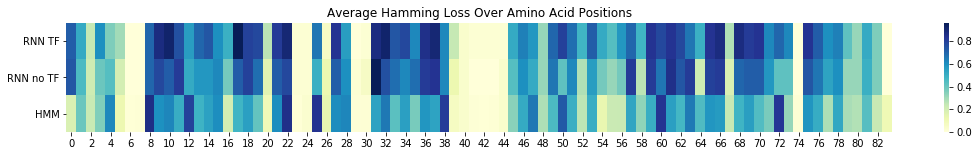

In [46]:
import seaborn as sb
# print(RNN_position_losses.shape, position_losses.shape)
#RNN_position_losses /= 50 

position_losses = position_losses.reshape(1, 84)

fig = plt.gcf()
fig.set_size_inches(18.5, 2)

position_losses_all = np.vstack([ RNN_position_losses_tf, RNN_position_losses, position_losses])
sb.heatmap(position_losses_all, cmap="YlGnBu",yticklabels= ['RNN TF', 'RNN no TF',  'HMM'])

plt.title('Average Hamming Loss Over Amino Acid Positions')
plt.show()

In [6]:
# predicted, reals = ReadTxt('RNN512_output.txt')

# RNN_position_losses_tf = np.zeros(84)
# for position in range(83):
#     RNN_position_losses_tf[position] = hamming_loss( reals[:, position+1], predicted[:, position]   )
# RNN_position_losses_tf = RNN_position_losses_tf.reshape(1, 84)

    
predicted, reals = ReadTxt('protein_no_tf.txt')

RNN_position_losses = np.zeros(84)
for position in range(83):
    RNN_position_losses[position] = hamming_loss( reals[:, position+1], predicted[:, position]   )
RNN_position_losses = RNN_position_losses.reshape(1, 84)

predicted and real sizes:  (50, 85) (50, 85)


0.80720000000000003

In [14]:
predicted, reals = ReadTxt('protein_no_tf.txt')
sample_loss = 0
for index, row in enumerate(predicted):
    sample_loss += hamming_loss(reals[index, 1:], predicted[index, :-1])
    
sample_loss/=50
sample_loss

predicted and real sizes:  (50, 85) (50, 85)


0.48333333333333306

In [35]:
#hamming_loss( reals.reshape(-1), predicted.reshape(-1)  )

array([23, 10,  8, 19, 10,  6, 10,  0,  0, 13, 20,  9, 18, 18,  4, 18,  4,
       10, 15,  4, 22,  5,  4, 14,  0,  0,  5,  6,  4, 10,  0,  0, 10, 11,
        1, 14, 19,  9,  9,  3,  0,  0,  0,  0,  0,  0, 13,  4, 18,  6, 10,
       16,  9,  6,  5,  6,  5,  8, 15,  5,  6,  3, 22,  3, 18, 14,  9, 14,
       19,  8, 14,  9, 15,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [34]:
predicted[0]

array([10,  5, 19, 15,  6, 10,  0,  0, 13, 22,  4, 19, 18,  4, 14,  3, 10,
        4,  4, 19,  5,  9,  4,  0,  0, 22,  6,  9,  8,  0,  0, 19, 16, 19,
       15, 19, 16, 19,  0,  0,  0,  0,  0,  0,  0,  0,  7, 18,  6, 15,  4,
        9,  6, 16,  6, 22, 19,  4,  5, 16,  3,  8,  3,  4, 19, 14,  9,  1,
       10,  3, 12, 11,  3,  3,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0])

### TODO

# PROTEIN DATA
#train/test split for HMM

# protein loss 


#SYNTHETIC DATA 
#    Error   Pattern Error
#HMM
#RNN

#% variance explained